## Kaytoo | Inference Notebook

### Bird Call Classification for New Zealand birds

## Basic Setup
Adjust the dictionary below for the overall notebook use case.  Note that I am processing different sound clips in parallel.  If using the GPU this results in multiple batches being sent to the GPU by different cores, so the number of cores needs to be reduced.  With 4Gb VRAM, max num_cores is 2.  This is still faster than CPU only with 6 cores.  

**Benchmarking on 39 x 15-minute .wav files on a Dell G7**

- 2-cores GPU = 55 seconds
- 6-cores CPU = 103 seconds

In [44]:
notebook_use = {
                'project_root': '/media/olly/Red_SSD/Kaggle_BC25', 
                'bird_list': '/media/olly/Red_SSD/Kaggle_BC25/Data/Experiments/Exp_1/Exp_1_Deploy/exp_1_bird_map.csv',
                'naming_scheme' : 'eBird', #'Scientific', #'Short, Long, Scientific, eBird'
                'folder_to_process': '/media/olly/Red_SSD/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes',
                'model_choices': [0],
                'cpu_only': True,
                'num_cores': 2  #Can crank this up if using CPU only.
                }

## Imports

In [45]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
import json
from joblib import Parallel, delayed
import os

#Math & Plotting
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#Machine Learning 
import albumentations as A

#Torch and PyTorch specific
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import  DataLoader, Dataset
from torchaudio.functional import compute_deltas

#Audio
import librosa
import torchaudio
from scipy.signal import resample

#Helpers
from kaytoo_infer import open_audio_clip, get_images
from bird_naming_utils import BirdNamer

print('Imports Complete')

Imports Complete


## Configuration Classes

In [46]:
class DefaultConfig:
    def __init__(self, paths, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['cpu_only']:
                self.device = torch.device('cpu')
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1

        with open(paths.EBIRD_LIST_PATH, 'r') as file:
            self.classes = json.load(file)

class DefaultConfig:
    def __init__(self, bird_namer, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['cpu_only']:
                self.device = torch.device('cpu')
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1
        self.classes = bird_namer.bird_list
        self.naming = options['naming_scheme']

In [47]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [48]:
class ModelParameters:
   def __init__(self, options=None):
        self.parameters = [
        {'basename':'tf_efficientnet_b0.ns_jft_in1k',  #Exp_116 LB66, 43 minutes, uses Googlebirds_25 for 7 epochs
                         'ckpt_path':'/media/olly/Red_SSD/Kaggle_BC25/Data/Experiments/Exp_1/Results/last.ckpt',
                         #'ckpt_path': '/media/olly/T7/Kaytoo/Data/Experiments/Exp_2/Results/epoch=12-step=68337.ckpt',
                         'image_shape': (1,2), #The layout of 5-sec spectrograms stacked into the final image (height x width)
                         'image_time': 10,
                         'n_mels': 256,
                         'n_fft': 2048,
                         'use_deltas' : True,
                         'hop_length': 1243,
                         '5_sec_width': 128,
                         'aggregation': 'mean',
                         }, 
        ]
        if options and options.get('model_choice'):
            model_choices = options['model_choice']
            _parameters_list = [_parameters_list[i] for i in model_choices] 

In [49]:
class Models:
    def __init__(self, config, model_parameters, audio_parameters):
        self.args_list = model_parameters.parameters
        self.audio = audio_parameters
        self.ebirds = config.classes
        self.device = config.device

    def get_model(self, idx):
        model_args = self.args_list[idx]
        path = model_args['ckpt_path']
        map_location = 'cpu' if self.device == torch.device('cpu') else 'cuda'
        ckpt = torch.load(path, map_location=map_location)
        model = BirdSoundModel(self.ebirds, model_args)
        model.load_state_dict(ckpt)
        model.eval()
        model.parameters = self.args_list[idx]
        model.audio = self.audio
        model.to(self.device)
        return model     


In [50]:
class FilePaths:
    def __init__(self, options=None):
        self.bird_list_path = Path(options['bird_list'])
        self.SOUNDSCAPE_FLDR = Path(options['folder_to_process'])
        audio_types = {'.ogg','.wav', '.flac', '.mp3'}
        self.soundscapes = [path for path in self.SOUNDSCAPE_FLDR.rglob('*') if path.suffix in audio_types]
        self.PREDICTIONS_CSV = self.SOUNDSCAPE_FLDR / 'predictions.csv'

## Helper Functions

In [51]:
def compute_melspec(y, sr, hop_length, n_mels, n_fft, audio_params):
    if audio_params:
        fmin = audio_params.FMIN
        fmax = audio_params.FMAX
    else:
        fmin = 40
        fmax = 14000

    melspec = librosa.feature.melspectrogram(y=y, 
                                             sr=sr, 
                                             n_mels=n_mels, 
                                             n_fft=n_fft, 
                                             hop_length = hop_length, 
                                             fmin=fmin, 
                                             fmax=fmax
                                            ) 
    return librosa.power_to_db(melspec)


def mono_to_color(X, eps=1e-6, use_deltas=False):
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        X = (X - _min) / (_max - _min) #scales to a range of [0,1]
        X = X.astype(np.float32)
    else:
        X = np.zeros_like(X, dtype=np.float32)
    
    if use_deltas:
        T = torch.tensor(X, dtype=torch.float32)
        delta = compute_deltas(T)
        delta_2 = compute_deltas(delta)
        delta, delta_2 = delta.numpy(), delta_2.numpy()
        X=np.stack([X, delta, delta_2], axis=-1)
    else:
        X = np.stack([X, X, X], axis=-1) #puts the chanels last, like a normal image

    return X


def crop_or_pad(y, length, train='train'):
    y = np.concatenate([y, y, y])
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if train != 'train':
            start = 0
        else:
            start = np.random.randint(len(y) - length)
        y = y[start: start + length]
    return y
      

def prediction_for_clip(audio_path,
                        model,
                        sub_process=False):
    model_args=model.parameters
    audio_params=model.audio
    device = model.device 
    
    image_dict, num_extras = get_images(audio_path, model_args, audio_params)
    num_images = len(image_dict)
    dataset = ImageDataset(image_dict, model_args['image_shape'], model_args['use_deltas'])
    shape = model_args['image_shape']
    num_chunks = shape[0] * shape[1]
    batch_size = num_images // num_chunks  #should be a whole number, because we made sure of this in the get_images
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
    
    if not sub_process:
        progress = tqdm(range(len(loader)), desc="Inferring a single soundscape")
    
    for images, batch_idxs, in loader:
        row_idxs = batch_idxs.tolist()
        images=images.to(device)

        with torch.no_grad():
            predictions = model(images)  
            batch_segment_preds = predictions.detach().cpu().numpy()  #batch_size x num_chunks x num_classes
      
        if not sub_process:
            progress.update(1)

    del loader, dataset, image_dict
    if device == torch.device('cuda'):
        torch.cuda.empty_cache()

    #Now let's lop off the last num_extras predictions, as these were made on place-holding random noise
    if num_extras:
        batch_segment_preds = batch_segment_preds[:-num_extras, :]

    return batch_segment_preds


def show_batch(img_ds, model_args, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, len(img_ds)-1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first 9 images
        img, _ = img_ds[index]  #returns an image of n chunks
        shape=img.shape
        scaled_data = (img[0] - np.min(img[0])) / (np.max(img[0]) - np.min(img[0]))
        img = librosa.display.specshow(scaled_data, 
                                       x_axis='time', 
                                       y_axis='mel', 
                                       sr=32000, 
                                       n_fft=model_args['n_fft'] * model_args['image_shape'][0],
                                       hop_length=model_args['hop_length'],
                                       ax=ax)
        ax.set(title=f'Loading Index {index}, shape: {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")    
        
        
def process_clip(audio_path, model):
    clip_preds = []
    final_row_ids = []
    batch_preds = prediction_for_clip(audio_path,
                                      model,
                                      sub_process=True)
    
    num_preds = batch_preds.shape[0]
    
    for idx in range(num_preds):
        row = batch_preds[idx]
        clip_preds.append(row)
    
    row_ids = [audio_path.stem + f'_{end}' for end in range(5, (num_preds+1)*5, 5)]
    final_row_ids.extend(row_ids)

    return clip_preds, final_row_ids


def inference(test_audios, models, model_idx, cores=1):
    bird_list = models.ebirds
    model = models.get_model(model_idx)
    results = Parallel(n_jobs=cores)(
        delayed(process_clip)(audio_path, model=model) for audio_path in tqdm(test_audios, desc="Overall File List")
        )
    
    del model
    if models.device == torch.device('cuda'):
        torch.cuda.empty_cache()

    clip_preds = [result[0] for result in results]      #This should be a list of 1 x num_classes arrays, with a length = the number of predictions
    final_row_ids = [result[1] for result in results]   #This should be a list of row id's?

    clip_preds = [item for sublist in clip_preds for item in sublist]
    final_row_ids = [item for sublist in final_row_ids for item in sublist]
    prediction_df = pd.DataFrame(clip_preds, columns=bird_list)
    prediction_df.insert(0, 'row_id', final_row_ids)
    
    return prediction_df

## Augmentation Classes

In [52]:
class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray, sr):
        for trns in self.transforms:
            y = trns(y, sr)
        return y
    

class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray, sr):
        if self.always_apply:
            return self.apply(y, sr=sr)
        else:
            if np.random.rand() < self.p:
                return self.apply(y, sr=sr)
            else:
                return y

    def apply(self, y: np.ndarray, **params):
        raise NotImplementedError
    
    
class Normalize(AudioTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply, p)

    def apply(self, y: np.ndarray, **params):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)
    

class AbluTransforms():
    mean = (0.485, 0.456, 0.406) # RGB
    std = (0.229, 0.224, 0.225) # RGB
    
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.valid = A.Compose([
                        A.PadIfNeeded(min_height=self.height, min_width=self.width),
                        A.CenterCrop(width=self.width, height=self.height),
                        A.Normalize(self.mean, self.std, max_pixel_value=1.0,always_apply=True),
                        ])
    
class PrepareImage():
    mean = .5
    std = .22
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.prep = A.Compose([
            A.PadIfNeeded(min_height=self.height, min_width=self.width),
            A.CenterCrop(width=self.width, height=self.height),
            A.Normalize(mean=self.mean, std=self.std, max_pixel_value=1.0, always_apply=True),
        ])

## Dataset Definition

In [53]:
class ImageDataset(Dataset):
    def __init__(self, image_dict, image_shape, use_deltas): #, model_args
        self.image_dict = image_dict
        self.image_shape = image_shape
        self.image_pixels = self.image_dict[0].shape
        self.height = self.image_shape[0] * self.image_pixels[0]  #Shape of the combined image from one __get_item__
        self.width = self.image_shape[1] * self.image_pixels[1] 
        self.image_transform = AbluTransforms(height=self.height, width=self.width).valid
        self.use_deltas = use_deltas
        self.chunks_per_image = self.image_shape[0] * self.image_shape[1]
               
    def __len__(self):
        whole = len(self.image_dict) // self.chunks_per_image
        remainder =  1 if len(self.image_dict) % self.chunks_per_image != 0 else 0
        return  whole + remainder

    def __getitem__(self, idx):
        base = idx * self.chunks_per_image
        chunk_idxs = [base + n for n in range(self.chunks_per_image)]
        images = [self.image_dict[img_id] for img_id in chunk_idxs]
        
        if self.image_shape == (2,2):  #The (2,2) case 
            image = np.vstack((np.hstack((images[0], images[1])),   
                               np.hstack((images[2], images[3]))))
        elif self.image_shape == (1,2):  
            image = np.hstack((images[0], images[1]))
        elif self.image_shape == (2,1): 
            image = np.vstack((images[0], images[1]))
        elif self.image_shape == (1,4):
            image = np.hstack((images[0], images[1], images[2], images[3]))
        else:
            image = images[0]

        image = mono_to_color(image, use_deltas=self.use_deltas)
        image = self.image_transform(image=image)['image']
        image = image.transpose(2,0,1).astype(np.float32) # swapping the image channels to the first axis
        return image, idx

## Model Definition

In [ ]:
class BirdSoundModel(pl.LightningModule):

    def init_layer(self, layer):
        nn.init.xavier_uniform_(layer.weight)
        if hasattr(layer, "bias"):
            if layer.bias is not None:
                layer.bias.data.fill_(0.)

    def init_bn(self, bn):
        bn.bias.data.fill_(0.)
        bn.weight.data.fill_(1.0)
        
    def init_weight(self):
        self.init_bn(self.bn0)
        self.init_layer(self.fc1)


    class AttentionBlock(nn.Module):
        def __init__(self,
                     in_features: int,
                     out_features: int,
                     shape:tuple,
                     activation="linear",
                     aggregation='mean',
                    ):
            super().__init__()

            self.activation = activation
            self.attention = nn.Conv1d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True)
            self.classify = nn.Conv1d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True)
            self.init_weights()
            self.chunks_high = shape[0]
            self.chunks_wide = shape[1]
            self.num_chunks = shape[0] * shape[1]
            self.aggregation = aggregation
        
        def init_layer(self, layer): #could access the outer class init_layer method instead
            nn.init.xavier_uniform_(layer.weight)
            if hasattr(layer, "bias"):
                if layer.bias is not None:
                    layer.bias.data.fill_(0.)
               
        def init_weights(self):
            self.init_layer(self.attention)
            self.init_layer(self.classify)

        def nonlinear_transform(self, x):
            if self.activation == 'linear':
                return x
            elif self.activation == 'sigmoid':
                return torch.sigmoid(x)

        def forward(self, x):
            batch_size = x.shape[0]
            split_length = x.shape[2] // self.num_chunks  #The number of segments per 5 sec time chunk
            splits = torch.split(x, split_length, dim=2)
            x = torch.cat(splits, dim=0)
            
            norm_att = torch.softmax(torch.tanh(self.attention(x)), dim=-1) / (16//split_length)  # /4 or 2 or 1 so the 16 values sum to 1
            classify_logits = self.classify(x) 
            logits_with_attn  = norm_att * classify_logits * self.num_chunks
            

            if self.aggregation == 'mean':
                chunk_preds = self.nonlinear_transform(logits_with_attn.sum(dim=2, keepdim=True))
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
            
            elif self.aggregation == 'mean-max':
                chunk_preds = self.nonlinear_transform((logits_with_attn * self.num_chunks).sum(dim=2, keepdim=True))
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds_mean = torch.cat(chunk_splits, dim=2)
                
                chunk_logits_max, _ = classify_logits.max(dim=2, keepdim=True)
                chunk_preds_max = self.nonlinear_transform(chunk_logits_max)
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
                
                chunk_preds = (chunk_preds_mean + chunk_preds_max) / 2
            
            elif self.aggregation =='max':
                chunk_logits_max, _ = classify_logits.max(dim=2, keepdim=True)
                chunk_preds = self.nonlinear_transform(chunk_logits_max)
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
            
            chunk_preds = chunk_preds.transpose(1,2) #Putting the class predictions last
            chunk_preds = chunk_preds.reshape(chunk_preds.shape[0]*chunk_preds.shape[1], -1)  #flatten to (num_preds,num_classes)
                        
            return chunk_preds

    
    def __init__(self, 
                 classes, 
                 kwargs,
                 in_channels=3,
                ):
        super().__init__()
        
        self.image_time = kwargs['image_time'] # The total length of time represented by one complete image
        self.spec_height = kwargs['n_mels'] # The height of each spectrogram, before any stacking into an image
        self.chunk_width = kwargs['5_sec_width'] # The width of each spectrogram, before any stacking into an image
        self.image_shape = kwargs['image_shape'] # The spectrogram arrangement into an image (2,2) or (1,1) or (1,2), height x width
        self.base_model_name = kwargs['basename']
        self.aggregation = kwargs['aggregation']
        self.classes = classes
        self.num_classes = len(classes)
        
        self.image_width = self.image_shape[1] * self.chunk_width
        self.bn0 = nn.BatchNorm2d(3)   #self.image_width  #why is this still 256???
        
        self.base_model = timm.create_model(
                                    self.base_model_name, 
                                    pretrained=False, 
                                    in_chans=in_channels,
                                    )
        layers = list(self.base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if hasattr(self.base_model, "fc"):
            in_features = self.base_model.fc.in_features
        elif self.base_model_name == 'eca_nfnet_l0':
            in_features = self.base_model.head.fc.in_features
        elif self.base_model_name == 'convnext_tiny.in12k_ft_in1k':
            in_features = self.base_model.head.fc.in_features
        else:
            in_features = self.base_model.classifier.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = self.AttentionBlock(in_features, 
                                            self.num_classes,
                                            self.image_shape,
                                            activation="sigmoid",
                                            aggregation = self.aggregation,
                                            )
        self.init_weight()
        self.val_outputs = []
        self.train_outputs = []
        self.metrics_list = []
        self.val_epoch = 0
        

    def forward(self, input_data):
        x = input_data  #(batch_size, 3, frequency, time)  #This needs to match the the output of dataloader & getitem 
        x = x.transpose(1, 3)  #(batch_size, mel_bins, time_steps, channels)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        x = self.encoder(x)  #This is the image passing through the base model  8x8 out with a 256x256 original image
        
        if self.image_shape == (2,2):  #Stack the (1,2) and (2,2) scenarios in the frequency direction
            half = x.shape[2]//2
            x0 = x[:,:,:half,:half]
            x1 = x[:,:,:half,half:]
            x2 = x[:,:,half:,:half]
            x3 = x[:,:,half:,half:]
            x = torch.cat((x0,x1,x2,x3), dim=2) #stack vertically along the frequency direction, so now it's 16 high, 4 wide for a 256x256 input image
        elif self.image_shape == (1,4):  #Stack the (1,2) and (2,2) scenarios in the frequency direction
            quarter = x.shape[2]//4
            x0 = x[:,:,:,:quarter]
            x1 = x[:,:,:,quarter:2*quarter]
            x2 = x[:,:,:,2*quarter:3*quarter]
            x3 = x[:,:,:,3*quarter:]
            x = torch.cat((x0,x1,x2,x3), dim=2) #stack vertically along the frequency direction, so now it's 16 high, 4 wide for a 256x256 input image
        elif self.image_shape == (1,2):
            half = x.shape[3]//2
            x0 = x[:,:,:,:half]
            x1 = x[:,:,:,half:]
            x = torch.cat((x0,x1), dim=2) #For a 128x128 (2,1) image, we'd now have 8 high in frequency, 2 wide in time
        
        #This is the guts of the SED part.
        x = torch.mean(x, dim=3) # Aggregate in the horizontal (time) axis, so now we've just got a 3d tensor (batch_size, n_features, freq-time chunks)       
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        
        chunk_preds = self.att_block(x)
        #print(chunk_preds.shape)
        return chunk_preds #(48,182) regardless of how the images were shaped

## Initialise

In [55]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
bird_map_df = pd.read_csv(paths.bird_list_path)
birdnames = BirdNamer(bird_map_df)

cfg = DefaultConfig(bird_namer=birdnames, options=notebook_use)
parameters = ModelParameters(options=notebook_use)
models = Models(config=cfg, 
                model_parameters=parameters, 
                audio_parameters=audio)
print('The inference folder is:', paths.SOUNDSCAPE_FLDR)
print(f'There are {len(models.args_list)} model(s) to be ensembled')
print(f'The model(s) will predict the following {len(models.ebirds)} birds (referring to their https://ebird.org code): \n')
for i in range(0, len(models.ebirds), 10):
    print(", ".join(models.ebirds[i:i + 10]))

print('\nThe first three recordings to be precessed are:')
for i in range(min(3, len(paths.soundscapes))):
    print(paths.soundscapes[i])

print('\nThe parameters for the first model are:')
for parameter, value in models.args_list[0].items():
    print(f'{parameter}: {value}')

The inference folder is: /media/olly/Red_SSD/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes
There are 1 model(s) to be ensembled
The model(s) will predict the following 201 birds (referring to their https://ebird.org code): 

1139490, 1192948, 1194042, 126247, 1346504, 134933, 135045, 1462711, 1462737, 21038
21211, 22333, 22973, 22976, 24272, 24292, 24322, 41663, 41778, 41970
42007, 42113, 46010, 47067, 476537, 476538, 48124, 50186, 517119, 528041
52884, 548639, 555086, 555142, 566513, 64862, 65336, 65344, 65349, 65373
65419, 65448, 65547, 65962, 66016, 66531, 66578, 66893, 67082, 67252
714022, 715170, 787625, 81930, 963335, amakin1, amekes, ampkin1, anhing, babwar
bafibi1, banana, baymac, bbwduc, bicwre1, bkcdon, bkmtou1, blbgra1, blbwre1, blcant4
blchaw1, blcjay1, blctit1, blhpar1, blkvul, bobfly1, bobher1, brtpar1, bubcur1, bubwre1
bucmot3, bugtan, butsal1, cargra1, cattyr, chbant1, chfmac1, cinbec1, cocher1, cocwoo1
colara1, colcha1, compau, compot1, cotfly1, crbtan1

## Varify on a Single Soundscape

In [56]:
#It woudl be cleaner to adjust the show_batch to handle any number of images

def repeat_dict_items(d, target_length):
    keys = list(d.keys())
    values = list(d.values())
    
    new_dict = {}
    i = 0
    while len(new_dict) < target_length:
        new_dict[keys[i % len(keys)] + len(new_dict) // len(keys) + 1] = values[i % len(keys)]
        i += 1
    
    return new_dict

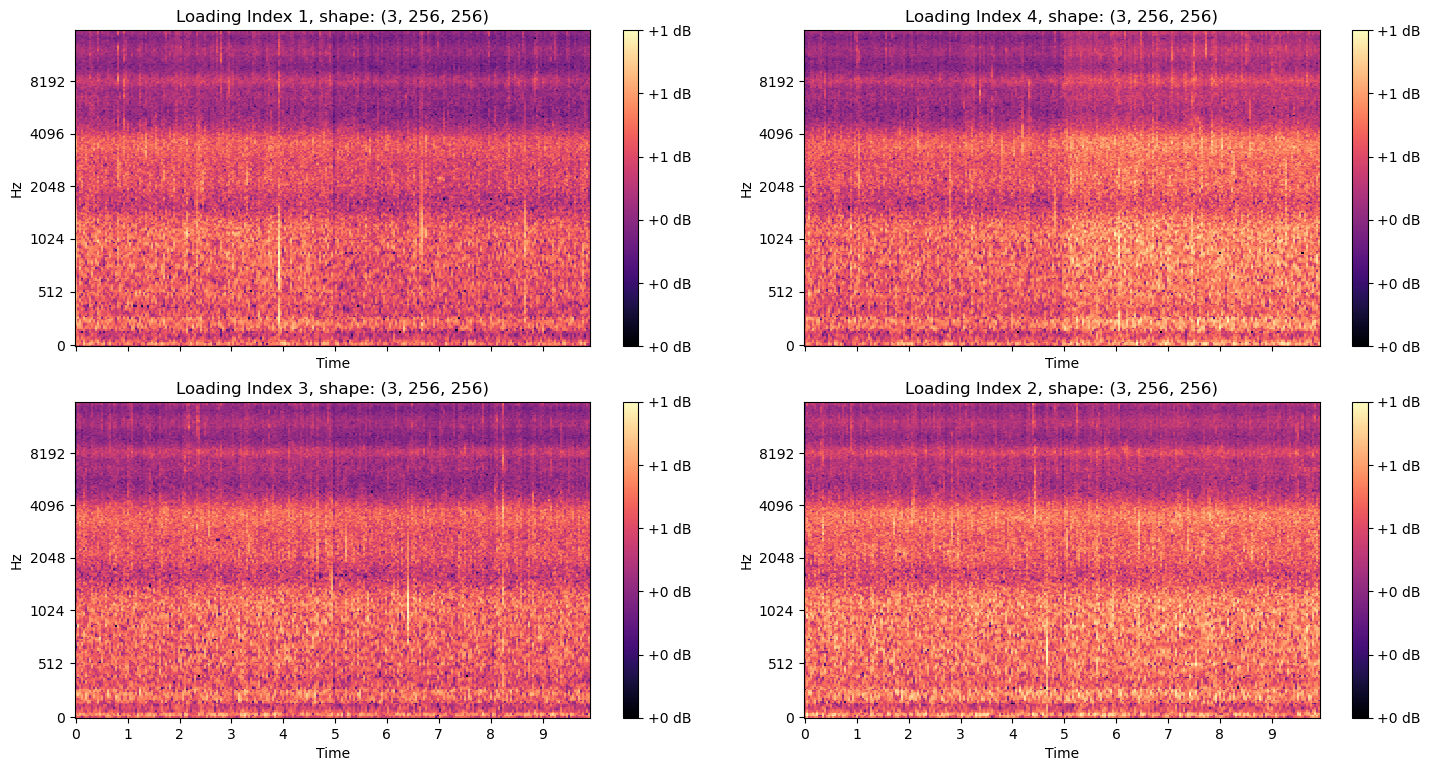

In [57]:
soundscape = random.choice(paths.soundscapes)
image_dict, num_extras = get_images(soundscape, models.args_list[0], audio_params=models.audio)
if len(image_dict)<=8:
    image_dict = repeat_dict_items(image_dict, 8)
image_shape = models.args_list[0]['image_shape']
use_deltas = models.args_list[0]['use_deltas']
dataset = ImageDataset(image_dict, image_shape, use_deltas)
show_batch(dataset, models.args_list[0], 2,2)

In [58]:
model = models.get_model(0)
clip_prediction = prediction_for_clip(random.choice(paths.soundscapes), model)
print(f'The shape of the clip predictions array is {clip_prediction.shape}')

Inferring a single soundscape:   0%|          | 0/1 [00:00<?, ?it/s]

The shape of the clip predictions array is (12, 201)


## Prediction in 5 second intervals

In [59]:
test_audios = paths.soundscapes #[:2]

In [60]:
prediction_dfs = []
#Note: There is an inherent inefficiency here if using models that share the same spectrograms, as spectrogram generation is repeated for each model.
#My assumption was that different models in any ensemble I make will be based on different spectrogram parameters
for idx in range(len(models.args_list)):
    df = inference(test_audios, models, idx, cores=cfg.CORES)
    prediction_dfs.append(df)

Overall File List:   0%|          | 0/11 [00:00<?, ?it/s]

Average the various prediction dataframes

In [61]:
prediction_columns = prediction_dfs[0].columns[1:]
values_list = [df[prediction_columns].values for df in prediction_dfs]
average_vals = np.zeros_like(values_list[0])

for array in values_list:
    average_vals = average_vals + array 

average_vals = average_vals / len(values_list)
submission = pd.DataFrame(data=average_vals, columns=prediction_columns)
submission.insert(0, 'row_id', prediction_dfs[0]['row_id']) 

In [62]:
submission.to_csv(paths.PREDICTIONS_CSV, index=False)

In [63]:
pd.read_csv(paths.PREDICTIONS_CSV)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.054956,0.029815,0.053783,0.035514,0.255322,0.061674,0.096547,0.035485,0.031109,...,0.030399,0.054326,0.078507,0.032954,0.026531,0.051870,0.022613,0.034864,0.037301,0.107622
1,H02_20230420_074000_10,0.058497,0.031091,0.058454,0.041069,0.263954,0.065547,0.105011,0.039858,0.032513,...,0.031641,0.064009,0.080309,0.031966,0.029833,0.055301,0.024384,0.042561,0.045342,0.118911
2,H02_20230420_074000_15,0.045816,0.025535,0.054922,0.030917,0.203102,0.072170,0.090358,0.015604,0.020230,...,0.020015,0.035182,0.037918,0.016544,0.017950,0.020125,0.022704,0.022726,0.026058,0.135733
3,H02_20230420_074000_20,0.052980,0.025088,0.059773,0.038400,0.195958,0.083626,0.101076,0.019456,0.026433,...,0.021474,0.042940,0.043327,0.019644,0.021771,0.024255,0.025713,0.027083,0.035132,0.151573
4,H02_20230420_074000_25,0.075179,0.026281,0.052874,0.055881,0.305256,0.082390,0.093534,0.027607,0.021537,...,0.036258,0.065108,0.078119,0.022561,0.040215,0.046764,0.021271,0.030419,0.029121,0.137058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,H02_20230422_014500_40,0.041096,0.017383,0.075870,0.013499,0.187444,0.038439,0.063198,0.016176,0.007846,...,0.011521,0.019422,0.028589,0.056625,0.059106,0.017084,0.009979,0.020439,0.027209,0.036875
128,H02_20230422_014500_45,0.068281,0.027076,0.113059,0.031919,0.377619,0.030202,0.137414,0.011452,0.004539,...,0.016713,0.018151,0.042689,0.026485,0.108655,0.027048,0.011721,0.023103,0.023156,0.037480
129,H02_20230422_014500_50,0.070495,0.025209,0.098347,0.034996,0.362237,0.027144,0.133032,0.011410,0.004435,...,0.015661,0.017426,0.039530,0.025676,0.109246,0.029231,0.012265,0.024146,0.023827,0.045459
130,H02_20230422_014500_55,0.048606,0.018840,0.090214,0.018142,0.217933,0.020411,0.055294,0.011327,0.007028,...,0.012128,0.010575,0.019335,0.018079,0.103609,0.011221,0.010393,0.012712,0.029298,0.020887
